In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 가짜리뷰 의심 문장 추출
 - 리뷰의 길이 하위 10%(22자 이하)는 고려하지 않음
 - 각 리뷰를 문장 토큰화하여 서로 정확히 일치하는 문장만 필터링
 - 중복 크롤링과 한 사업장 내의 중복 게시를 제거하기 위해, 일치하는 문장이 다른 URL일 경우만 가짜 리뷰 의심 문장으로 간주

In [ ]:
import pandas as pd

In [ ]:
df_sentence = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Team2_Final/23자이상_네이버카카오kss.xlsx")
df_sentence.head()

,Review URL,Review Text,Review ID,사업장명,글자수
0,https://pcmap.place.naver.com/place/1725787145...,여기 다닌지 3년정도 다닌 후기 입니다,0,24시PT앤태닝,21
1,https://pcmap.place.naver.com/place/1725787145...,우선 헬스장이 24시간이어서 언제든지 운동가능하고 항상 시원하고 쾌적해요,0,24시PT앤태닝,40
2,https://pcmap.place.naver.com/place/1725787145...,무엇보다 피티는 일반 피티 운동기구 3-4개 하고 3세트씩 하는곳과 차원이 달라요,0,24시PT앤태닝,45
3,https://pcmap.place.naver.com/place/1725787145...,피티는 하체 복부 상체 일반헬스장 다 따로 하는데 여기는 같이 토탈적 으로 잦아주면...,0,24시PT앤태닝,109
4,https://pcmap.place.naver.com/place/1725787145...,먼저 헬스장이 24시간 열려있다보니 언제든 편하게 가서 운동을 할 수 있다는게 너무...,1,24시PT앤태닝,53


In [ ]:
# 열 순서 변경
df_sentence = df_sentence[["Review ID", "사업장명", "Review Text", "글자수", "Review URL"]]

# 열 이름 변경
df_sentence = df_sentence.rename(columns={"Review ID": "리뷰ID", "사업장명": "사업장명", "Review Text": "리뷰문장토큰", "글자수": "글자수", "Review URL": "URL"})

df_sentence.head()

,리뷰ID,사업장명,리뷰문장토큰,글자수,URL
0,0,24시PT앤태닝,여기 다닌지 3년정도 다닌 후기 입니다,21,https://pcmap.place.naver.com/place/1725787145...
1,0,24시PT앤태닝,우선 헬스장이 24시간이어서 언제든지 운동가능하고 항상 시원하고 쾌적해요,40,https://pcmap.place.naver.com/place/1725787145...
2,0,24시PT앤태닝,무엇보다 피티는 일반 피티 운동기구 3-4개 하고 3세트씩 하는곳과 차원이 달라요,45,https://pcmap.place.naver.com/place/1725787145...
3,0,24시PT앤태닝,피티는 하체 복부 상체 일반헬스장 다 따로 하는데 여기는 같이 토탈적 으로 잦아주면...,109,https://pcmap.place.naver.com/place/1725787145...
4,1,24시PT앤태닝,먼저 헬스장이 24시간 열려있다보니 언제든 편하게 가서 운동을 할 수 있다는게 너무...,53,https://pcmap.place.naver.com/place/1725787145...


In [ ]:
# "Review Text"의 글자수가 23글자 이상인 데이터를 추출
df_len_over23 = df_sentence[df_sentence["리뷰문장토큰"].str.len() >= 23]
# df_len_over23 = df_len_over23.set_index("Review ID")

df_len_over23.head()

,리뷰ID,사업장명,리뷰문장토큰,글자수,URL
1,0,24시PT앤태닝,우선 헬스장이 24시간이어서 언제든지 운동가능하고 항상 시원하고 쾌적해요,40,https://pcmap.place.naver.com/place/1725787145...
2,0,24시PT앤태닝,무엇보다 피티는 일반 피티 운동기구 3-4개 하고 3세트씩 하는곳과 차원이 달라요,45,https://pcmap.place.naver.com/place/1725787145...
3,0,24시PT앤태닝,피티는 하체 복부 상체 일반헬스장 다 따로 하는데 여기는 같이 토탈적 으로 잦아주면...,109,https://pcmap.place.naver.com/place/1725787145...
4,1,24시PT앤태닝,먼저 헬스장이 24시간 열려있다보니 언제든 편하게 가서 운동을 할 수 있다는게 너무...,53,https://pcmap.place.naver.com/place/1725787145...
5,1,24시PT앤태닝,운동을 하기에 앞서 체계적으로 짜여진 웜업으로 시작하는데 정말 좋습니다.,40,https://pcmap.place.naver.com/place/1725787145...


In [ ]:
# "Review Text"가 서로 같은 데이터 필터링
df_duplicate = df_len_over23[df_len_over23.duplicated(subset="리뷰문장토큰", keep=False)]

# "Review Text"가 서로 같은 데이터를 그룹화하여 각각의 행으로 만들어주기
df_result_expanded = df_duplicate.groupby("리뷰문장토큰").apply(lambda x: x.drop_duplicates(subset="리뷰ID"))

# "Review Text"와 "Review URL"이 모두 일치하는 데이터 삭제
df_result_filtered = df_result_expanded.drop_duplicates(subset=["리뷰문장토큰", "URL"], keep=False)

# "Review ID"를 기준으로 오름차순 정렬
df_result_filtered = df_result_filtered.sort_values(by="리뷰ID", ascending=True)

df_result_filtered.head()


<ipython-input-9-d6386be66746>:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_result_expanded = df_duplicate.groupby("리뷰문장토큰").apply(lambda x: x.drop_duplicates(subset="리뷰ID"))


,리뷰ID,사업장명,리뷰문장토큰,글자수,URL
1544,488,MN휘트니스 청담점,"운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 ...",66,https://pcmap.place.naver.com/place/37690479/home
1545,488,MN휘트니스 청담점,운동을 싫어하고 못하는 저도 자주 운동을 나올 수 있게끔 만들어주시는 선생님이십\n...,50,https://pcmap.place.naver.com/place/37690479/home
1546,488,MN휘트니스 청담점,앞으로의 수업도 너무 기대하고 있습니다 🤩,24,https://pcmap.place.naver.com/place/37690479/home
2599,797,SUIT GYM,매일 좋은 기분으로 운동할 수 있었습니다.,23,https://pcmap.place.naver.com/place/1013230203...
2601,797,SUIT GYM,이런 점은 편안하게 자신만의 운동을 즐길 수 있는 분위기를 만들어 줍니다.,41,https://pcmap.place.naver.com/place/1013230203...


In [ ]:
df_result_filtered

,리뷰ID,사업장명,리뷰문장토큰,글자수,URL
1544,488,MN휘트니스 청담점,"운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 ...",66,https://pcmap.place.naver.com/place/37690479/home
1545,488,MN휘트니스 청담점,운동을 싫어하고 못하는 저도 자주 운동을 나올 수 있게끔 만들어주시는 선생님이십\n...,50,https://pcmap.place.naver.com/place/37690479/home
1546,488,MN휘트니스 청담점,앞으로의 수업도 너무 기대하고 있습니다 🤩,24,https://pcmap.place.naver.com/place/37690479/home
2599,797,SUIT GYM,매일 좋은 기분으로 운동할 수 있었습니다.,23,https://pcmap.place.naver.com/place/1013230203...
2601,797,SUIT GYM,이런 점은 편안하게 자신만의 운동을 즐길 수 있는 분위기를 만들어 줍니다.,41,https://pcmap.place.naver.com/place/1013230203...
2607,799,SUIT GYM,운동을 좋아하지 않지만 이곳에서 PT받으면서 조금씩 좋아지고 있어 만족합니다.,43,https://pcmap.place.naver.com/place/1013230203...
2608,799,SUIT GYM,개인적으로 PT받으면 무조건 시계보면서 빨리 시간 가길 바라는편인데 여기선 금방 지...,51,https://pcmap.place.naver.com/place/1013230203...
2609,799,SUIT GYM,그만큼 제 자세와 몸에 집중하면서 수업 받게하는 트레이너의 스킬이 훌륭하다고 생각합...,50,https://pcmap.place.naver.com/place/1013230203...
2610,799,SUIT GYM,수업했던 운동에 대한 바른 자세와 힘이 들어가야되는 부분을 이미지로 보내줌으로써 수...,67,https://pcmap.place.naver.com/place/1013230203...
2621,802,SUIT GYM,회원들이 운동하는데 불편함이 없도록 항상 개선하려고 노력하는 헬스클럽이에요.,42,https://pcmap.place.naver.com/place/1013230203...


In [ ]:
# 가짜리뷰의 문장 갯수 46개
print("가짜리뷰의 문장 갯수: ", df_result_filtered.shape[0])

가짜리뷰의 문장 갯수:  46


In [ ]:
# 가짜리뷰의 리뷰ID 갯수 16개
unique_review_ids = df_result_filtered["리뷰ID"].nunique()
print("가짜리뷰 Review ID 갯수:", unique_review_ids)

가짜리뷰 Review ID 갯수: 16


In [ ]:
# 가짜리뷰 사업장명
fake_review_gym = df_result_filtered["사업장명"].unique().tolist()

# 가짜리뷰 사업장 갯수
fake_review_gym_qty = len(fake_review_gym)

# 리스트 원소 사이 줄바꿈 join 함수, 인덱싱 for문
numbered_fake_review_gym = "\n".join([f"{i+1}. {gym}" for i, gym in enumerate(fake_review_gym)])

print(f"가짜 리뷰 사업장 {fake_review_gym_qty}곳:\n{numbered_fake_review_gym}")

가짜 리뷰 사업장 9곳:
1. MN휘트니스 청담점
2. SUIT GYM
3. 버핏그라운드 역삼점
4. 샵피트니스
5. 에이블짐 강남역점
6. 피티 아지트 PT AZIT 
7. 휴메이크휘트니스 대치점
8. 휴메이크휘트니스 선정릉점
9. 휴메이크휘트니스 역삼점


In [ ]:
import openpyxl

# 데이터프레임을 엑셀 파일로 저장합니다.
df_result_filtered.to_excel("df_result_filtered.xlsx", index=False, engine='openpyxl')

# 파일을 다운로드합니다.
from google.colab import files
files.download("df_result_filtered.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2. 리뷰간 문장유사도

In [ ]:
df_review = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Team2_Final/1209full리뷰_w리뷰ID.xlsx")

# 열 순서 변경
df_review = df_review[["리뷰번호", "사업장명", "Review", "글자수", "URL"]]

# 열 이름 변경
df_review = df_review.rename(columns={"리뷰번호": "리뷰ID", "사업장명": "사업장명", "Review": "리뷰", "글자수": "글자수", "URL": "URL"})

df_review.head()

,리뷰ID,사업장명,리뷰,글자수,URL
0,0,24시PT앤태닝,여기 다닌지 3년정도 다닌 후기 입니다 우선 헬스장이 24시간이어서 언제든지 운동가능하고 항상 시원하고 쾌적해요 무엇보다 피티는 일반 피티 운동기구 3-4개 하고 3세트씩 ...,225,https://pcmap.place.naver.com/place/1725787145/home
1,1,24시PT앤태닝,먼저 헬스장이 24시간 열려있다보니 언제든 편하게 가서 운동을 할 수 있다는게 너무 좋습니다!! 운동을 하기에 앞서 체계적으로 짜여진 웜업으로 시작하는데 정말 좋습니다. 전...,232,https://pcmap.place.naver.com/place/1725787145/home
2,2,24시PT앤태닝,넘 좋아요 친절해요 언제가도 열료있어서 좋아요\n특히 기구가 잘 관리 돼서 좋아요!!,46,https://pcmap.place.naver.com/place/1725787145/home
3,3,24시PT앤태닝,혼자 운동하기 막막하신 분들 웜업부터 체계적인 프로그램까지 정말 꼼꼼하게 봐주세요!! 진짜 선생님만 믿고 꾸준히 운동하니까 체형이 자연스럽게 좋아지고 주위에서 먼저 알아봐서...,102,https://pcmap.place.naver.com/place/1725787145/home
4,4,24시PT앤태닝,요즘 24시간 헬스장이 흔치 않은데.프라이빗하게 내가 원하는 시간에 언제든 운동하는점이 좋았습니다. 관장님도 밤 11시까지 수업해주시는 열정적인 모습에. 3개월 동안 20키...,116,https://pcmap.place.naver.com/place/1725787145/home


In [ ]:
df_merged = df_review.merge(df_result_filtered[['리뷰ID']], on='리뷰ID', how='inner')
df_merged.head()

,리뷰ID,사업장명,리뷰,글자수,URL
0,488,MN휘트니스 청담점,"박민제 선생님께 OT 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",191,https://pcmap.place.naver.com/place/37690479/home
1,488,MN휘트니스 청담점,"박민제 선생님께 OT 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",191,https://pcmap.place.naver.com/place/37690479/home
2,488,MN휘트니스 청담점,"박민제 선생님께 OT 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",191,https://pcmap.place.naver.com/place/37690479/home
3,797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관리되어 있 어서 마음에 들었습니다. 매일 좋은 기...,229,https://pcmap.place.naver.com/place/1013230203/home
4,797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관리되어 있 어서 마음에 들었습니다. 매일 좋은 기...,229,https://pcmap.place.naver.com/place/1013230203/home


In [ ]:
# 고윳값만 남기기
df_merged = df_merged.drop_duplicates()
df_merged = df_merged.drop('글자수', axis=1)
df_merged.rename(columns={'URL': '네이버홈 URL'}, inplace=True)

df_merged

,리뷰ID,사업장명,리뷰,네이버홈 URL
0,488,MN휘트니스 청담점,"박민제 선생님께 OT 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",https://pcmap.place.naver.com/place/37690479/home
3,797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관리되어 있 어서 마음에 들었습니다. 매일 좋은 기...,https://pcmap.place.naver.com/place/1013230203/home
5,799,SUIT GYM,운동을 좋아하지 않지만 이곳에서 PT받으면서 조금씩 좋아지고 있어 만족합니다. 개인적으로 PT받으면 무조건 시계보면서 빨리 시간 가길 바라는편인데 여기선 금방 지나갑니다. ...,https://pcmap.place.naver.com/place/1013230203/home
9,802,SUIT GYM,회원들이 운동하는데 불편함이 없도록 항상 개선하려고 노력하는 헬스클럽이에요. 깨끗하고 인테리어도 심플하고 깔금해서 너무 좋더라구요! 그리고 무엇보다 처음 상담 했을때 되게 ...,https://pcmap.place.naver.com/place/1013230203/home
10,3248,버핏그라운드 역삼점,"회원들이 운동하는데 불편함이 없도록 항상 개선하려고 노력하는 헬스클럽이에요. 꺄끗하고 고급스러워서 비쌀거라는 선입견이 있으신 분들도 있으신데, 회비도 합리적이에요.",https://pcmap.place.naver.com/place/1113875786/home
11,3266,버핏그라운드 역삼점,6개월 가량 버핏그라운드 역삼점 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관 리되어 있어서 마음에 들었습니다. 매일 ...,https://pcmap.place.naver.com/place/1113875786/home
13,3846,샵피트니스,운동을 좋아하지 않지만 이곳에서 PT받으면서 조금씩 좋아지고 있어 만족합니다. 개인적으로 PT받으면 무조건 시계보면서 빨리 시간 가길 바라는편인데 여기선 금방 지나갑니다. ...,https://pcmap.place.naver.com/place/1906845355/home
17,5430,에이블짐 강남역점,"최준환 팀장님께 2번 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",https://pcmap.place.naver.com/place/1958479504/home
20,8873,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 다 경험해봤는데 양쪽 몸의 균형은 잘 맞지 않더라구요;; 그래서 몸의 균형을 맞추기 위해서 찾아갔는데요. 상담부터도 괜찮다는 ...",https://pcmap.place.naver.com/place/1526587017/home
24,8899,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 다 경험해봤는데 양쪽 몸의 균형은 잘 맞지 않더라구요;; 그래서 몸의 균형을 맞추기 위해서 찾아갔는데요. 상담부터도 괜찮다는 ...",https://place.map.kakao.com/387623739#comment


In [ ]:
pd.set_option('display.max_colwidth', 30)
df_merged

,리뷰ID,사업장명,리뷰,네이버홈 URL
0,488,MN휘트니스 청담점,박민제 선생님께 OT 수업 듣고 처음으로 PT ...,https://pcmap.place.naver....
3,797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에...,https://pcmap.place.naver....
5,799,SUIT GYM,운동을 좋아하지 않지만 이곳에서 PT받으면서 조...,https://pcmap.place.naver....
9,802,SUIT GYM,회원들이 운동하는데 불편함이 없도록 항상 개선하...,https://pcmap.place.naver....
10,3248,버핏그라운드 역삼점,회원들이 운동하는데 불편함이 없도록 항상 개선하...,https://pcmap.place.naver....
11,3266,버핏그라운드 역삼점,6개월 가량 버핏그라운드 역삼점 이용 후기입니다...,https://pcmap.place.naver....
13,3846,샵피트니스,운동을 좋아하지 않지만 이곳에서 PT받으면서 조...,https://pcmap.place.naver....
17,5430,에이블짐 강남역점,최준환 팀장님께 2번 수업 듣고 처음으로 PT ...,https://pcmap.place.naver....
20,8873,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 ...",https://pcmap.place.naver....
24,8899,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 ...",https://place.map.kakao.co...


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df_merged'
# If it's not, replace 'df_merged' with your actual DataFrame name

# Define the order
order_values = [1, 3, 5, 7, 8, 4, 6, 2, 9, 10, 11, 14, 12, 15, 13, 16]

# Add the '순서' column to the DataFrame
df_merged['순서'] = order_values

# Sort the DataFrame based on the '순서' column
df_merged = df_merged.sort_values(by='순서')

# Reset the index
df_merged = df_merged.reset_index(drop=True)

# Display the modified DataFrame
print(df_merged)


     리뷰ID             사업장명                             리뷰  \
0     488       MN휘트니스 청담점  박민제 선생님께 OT 수업 듣고 처음으로 PT ...   
1    5430        에이블짐 강남역점  최준환 팀장님께 2번 수업 듣고 처음으로 PT ...   
2     797         SUIT GYM  1개월 가량 역삼 수트짐 이용 후기입니다. 눈에...   
3    3266       버핏그라운드 역삼점  6개월 가량 버핏그라운드 역삼점 이용 후기입니다...   
4     799         SUIT GYM  운동을 좋아하지 않지만 이곳에서 PT받으면서 조...   
5    3846            샵피트니스  운동을 좋아하지 않지만 이곳에서 PT받으면서 조...   
6     802         SUIT GYM  회원들이 운동하는데 불편함이 없도록 항상 개선하...   
7    3248       버핏그라운드 역삼점  회원들이 운동하는데 불편함이 없도록 항상 개선하...   
8    8873  피티 아지트 PT AZIT   테니스, 각종 격투기, 클라이밍, 수영, 요가 ...   
9    8899  피티 아지트 PT AZIT   테니스, 각종 격투기, 클라이밍, 수영, 요가 ...   
10   9982     휴메이크휘트니스 대치점  저는 운동을 좋아해서 꾸준하게 헬스장을 다니고 ...   
11  10030    휴메이크휘트니스 선정릉점  저는 운동을 좋아해서 꾸준하게 헬스장을 다니고 ...   
12  10073     휴메이크휘트니스 역삼점  저는 운동을 좋아해서 꾸준하게 헬스장을 다니고 ...   
13   9989     휴메이크휘트니스 대치점  친구가 소개해 줘서 가입했는데 만족하며 다니고 ...   
14  10033    휴메이크휘트니스 선정릉점  친구가 소개해 줘서 가입했는데 만족하며 다니고 ...   
15  10081     휴메이크휘트니스 역

In [ ]:
df_merged

,리뷰ID,사업장명,리뷰,네이버홈 URL,순서
0,488,MN휘트니스 청담점,박민제 선생님께 OT 수업 듣고 처음으로 PT ...,https://pcmap.place.naver....,1
1,5430,에이블짐 강남역점,최준환 팀장님께 2번 수업 듣고 처음으로 PT ...,https://pcmap.place.naver....,2
2,797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에...,https://pcmap.place.naver....,3
3,3266,버핏그라운드 역삼점,6개월 가량 버핏그라운드 역삼점 이용 후기입니다...,https://pcmap.place.naver....,4
4,799,SUIT GYM,운동을 좋아하지 않지만 이곳에서 PT받으면서 조...,https://pcmap.place.naver....,5
5,3846,샵피트니스,운동을 좋아하지 않지만 이곳에서 PT받으면서 조...,https://pcmap.place.naver....,6
6,802,SUIT GYM,회원들이 운동하는데 불편함이 없도록 항상 개선하...,https://pcmap.place.naver....,7
7,3248,버핏그라운드 역삼점,회원들이 운동하는데 불편함이 없도록 항상 개선하...,https://pcmap.place.naver....,8
8,8873,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 ...",https://pcmap.place.naver....,9
9,8899,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 ...",https://place.map.kakao.co...,10


In [ ]:
# Extract unique values from the '사업장명' column
unique_gyms = df_merged['사업장명'].unique()

# Create a new DataFrame with the unique values
fake_gym = pd.DataFrame(unique_gyms, columns=['사업장명'])

# Display the 'fake_gym' DataFrame
print(fake_gym)

              사업장명
0       MN휘트니스 청담점
1         SUIT GYM
2       버핏그라운드 역삼점
3            샵피트니스
4        에이블짐 강남역점
5  피티 아지트 PT AZIT 
6     휴메이크휘트니스 대치점
7    휴메이크휘트니스 선정릉점
8     휴메이크휘트니스 역삼점


In [ ]:
fake_gym

,사업장명
0,MN휘트니스 청담점
1,SUIT GYM
2,버핏그라운드 역삼점
3,샵피트니스
4,에이블짐 강남역점
5,피티 아지트 PT AZIT
6,휴메이크휘트니스 대치점
7,휴메이크휘트니스 선정릉점
8,휴메이크휘트니스 역삼점


In [ ]:


# Set the '리뷰ID' column as the new index
# df_merged.set_index('리뷰ID', inplace=True)

# Adjust column width for '사업장명'
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 100)
# Rename 'URL' column to '네이버홈 URL'
df_merged.rename(columns={'URL': '네이버홈 URL'}, inplace=True)


# Display the modified DataFrame
df_merged


,사업장명,리뷰,네이버홈 URL
리뷰ID,,,
488,MN휘트니스 청담점,"박민제 선생님께 OT 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",https://pcmap.place.naver.com/place/37690479/home
797,SUIT GYM,1개월 가량 역삼 수트짐 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관리되어 있 어서 마음에 들었습니다. 매일 좋은 기...,https://pcmap.place.naver.com/place/1013230203/home
799,SUIT GYM,운동을 좋아하지 않지만 이곳에서 PT받으면서 조금씩 좋아지고 있어 만족합니다. 개인적으로 PT받으면 무조건 시계보면서 빨리 시간 가길 바라는편인데 여기선 금방 지나갑니다. ...,https://pcmap.place.naver.com/place/1013230203/home
802,SUIT GYM,회원들이 운동하는데 불편함이 없도록 항상 개선하려고 노력하는 헬스클럽이에요. 깨끗하고 인테리어도 심플하고 깔금해서 너무 좋더라구요! 그리고 무엇보다 처음 상담 했을때 되게 ...,https://pcmap.place.naver.com/place/1013230203/home
3248,버핏그라운드 역삼점,"회원들이 운동하는데 불편함이 없도록 항상 개선하려고 노력하는 헬스클럽이에요. 꺄끗하고 고급스러워서 비쌀거라는 선입견이 있으신 분들도 있으신데, 회비도 합리적이에요.",https://pcmap.place.naver.com/place/1113875786/home
3266,버핏그라운드 역삼점,6개월 가량 버핏그라운드 역삼점 이용 후기입니다. 눈에 띄는 것은 헬스장의 깔끔함입니다. 여러 운동 기구와 공간 전체가 청결하게 관 리되어 있어서 마음에 들었습니다. 매일 ...,https://pcmap.place.naver.com/place/1113875786/home
3846,샵피트니스,운동을 좋아하지 않지만 이곳에서 PT받으면서 조금씩 좋아지고 있어 만족합니다. 개인적으로 PT받으면 무조건 시계보면서 빨리 시간 가길 바라는편인데 여기선 금방 지나갑니다. ...,https://pcmap.place.naver.com/place/1906845355/home
5430,에이블짐 강남역점,"최준환 팀장님께 2번 수업 듣고 처음으로 PT 시작했어요!! 😄 운동을 제대로 해보는 것이 처음이고, 기초체력이 없는 상태인데도 저에\n게 맞춰서 잘 케어해주셔서 즐겁게~ ...",https://pcmap.place.naver.com/place/1958479504/home
8873,피티 아지트 PT AZIT,"테니스, 각종 격투기, 클라이밍, 수영, 요가 다 경험해봤는데 양쪽 몸의 균형은 잘 맞지 않더라구요;; 그래서 몸의 균형을 맞추기 위해서 찾아갔는데요. 상담부터도 괜찮다는 ...",https://pcmap.place.naver.com/place/1526587017/home


In [ ]:
df_merged.shape

(16, 5)

In [ ]:
# 데이터프레임을 엑셀 파일로 저장합니다.
df_merged.to_excel("df_merged.xlsx", index=False, engine='openpyxl')

# 파일을 다운로드합니다.
from google.colab import files
files.download("df_merged.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.font_manager as fm
import warnings

In [ ]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 120903 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


#### 코사인 유사도,
TF-IDF가 음의 값이 될 수 없으므로,
코사인 유사도는 0에서 1까지의값으로 표현된다.

In [ ]:
# 코사인 유사도 함수
def calculate_similarity(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return similarity_matrix

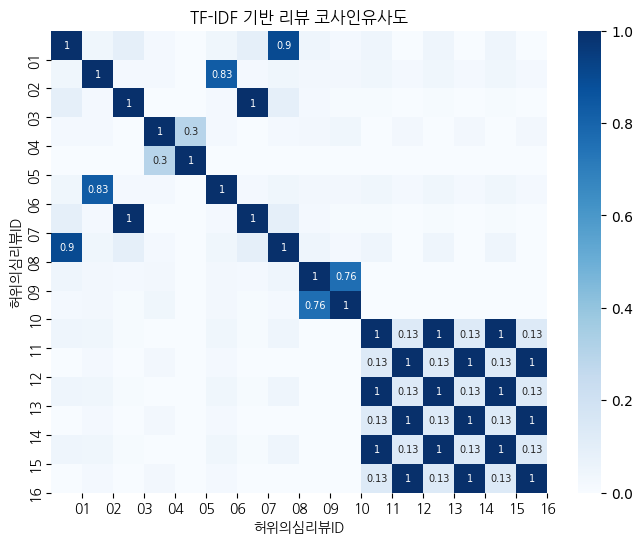

In [ ]:
# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# '리뷰' 열의 텍스트 추출
reviews = df_merged['리뷰'].tolist()

# 문장 유사도 행렬 계산
similarity_matrix = calculate_similarity(reviews)

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix.round(2), annot=True, cmap='Blues')
plt.title("TF-IDF 기반 리뷰 코사인유사도", fontproperties=font_prop, fontsize=12)
plt.xlabel("허위의심리뷰ID", fontproperties=font_prop)
plt.ylabel("허위의심리뷰ID", fontproperties=font_prop)

# xticks와 yticks 변경
plt.xticks(ticks=range(1, 17), labels=[f'{i:02d}' for i in range(1, 17)], fontproperties=font_prop)
plt.yticks(ticks=range(1, 17), labels=[f'{i:02d}' for i in range(1, 17)], fontproperties=font_prop)

# 텍스트 숨기기
for text in plt.gca().texts:
    if float(text.get_text()) < 0.1:
        text.set_text('')

# 숫자 폰트 크기 조정
plt.setp(plt.gca().texts, fontsize=7)

plt.show()

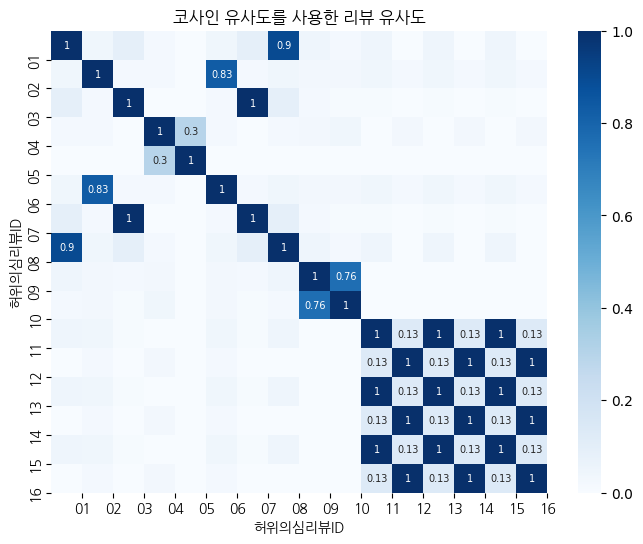

In [ ]:
# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# '리뷰' 열의 텍스트 추출
reviews = df_merged['리뷰'].tolist()

# 문장 유사도 행렬 계산
similarity_matrix = calculate_similarity(reviews)

# 히트맵 생성
plt.figure(figsize=(8, 6))
# sns.heatmap(similarity_matrix.round(2), annot=True, cmap='gist_yarg_r', vmin=0, vmax=1) #cmap YlOrRd bone
sns.heatmap(similarity_matrix.round(2), annot=True, cmap='Blues')
plt.title("코사인 유사도를 사용한 리뷰 유사도", fontproperties=font_prop, fontsize=12)
plt.xlabel("허위의심리뷰ID", fontproperties=font_prop)
plt.ylabel("허위의심리뷰ID", fontproperties=font_prop)

# 텍스트 숨기기
for text in plt.gca().texts:
    if float(text.get_text()) < 0.1:
        text.set_text('')

# xticks와 yticks 변경
plt.xticks(ticks=range(1, 17), labels=[f'{i:02d}' for i in range(1, 17)], fontproperties=font_prop)
plt.yticks(ticks=range(1, 17), labels=[f'{i:02d}' for i in range(1, 17)], fontproperties=font_prop)

# 숫자 폰트 크기 조정
plt.setp(plt.gca().texts, fontsize=7)

plt.show()

### 자카드유사도  
2개의 집합 A, B가 있을 때 두 집합의 합집합 중 교집합의 비율입니다. 즉, 두 집합이 완전히 같을 때는 자카드 유사도가 1이며, 두 집합에 교집합이 없는 경우는 0입니다.

자카드 유사도는 문서 간 단어 합집합의 원소 개수와 교집합의 원소 개수의 비율을 고려하기 때문에, 어떤 특정 단어가 몇 번씩이나 중복되었는지는 고려하지 않고 단지 얼마나 많은 다른 종류의 단어가 중복되었는지만 고려한다


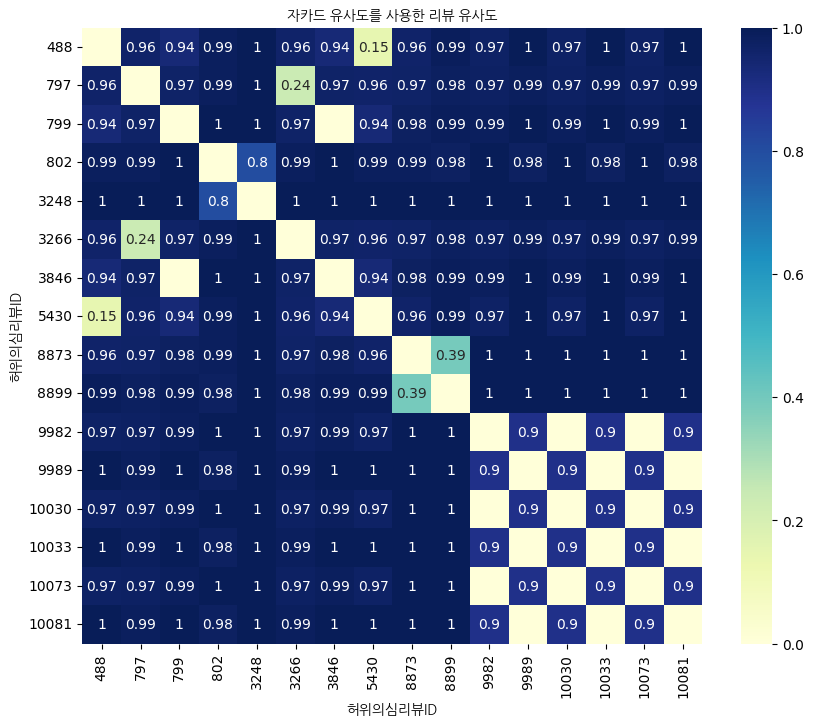

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

# CountVectorizer를 사용하여 문장을 단어의 집합으로 변환:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_merged['리뷰'])

# 희소 행렬을 일반적인 2차원 배열로 변환
X_dense = X.toarray()

# 자카드 유사도 계산
# pairwise_distances 함수를 사용하여 자카드 유사도를 계산합니다.
# metric='jaccard'로 설정하여 자카드 유사도를 계산합니다.
jaccard_distances = pairwise_distances(X_dense, metric='jaccard')

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 한글 폰트 파일의 경로를 지정해주세요.
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_distances, annot=True, cmap='YlGnBu', xticklabels=df_merged['리뷰ID'], yticklabels=df_merged['리뷰ID'])
plt.title("자카드 유사도를 사용한 리뷰 유사도", fontproperties=font_prop)
plt.xlabel("허위의심리뷰ID", fontproperties=font_prop)
plt.ylabel("허위의심리뷰ID", fontproperties=font_prop)

# 텍스트 숨기기
for text in plt.gca().texts:
    if float(text.get_text()) < 0.1:
        text.set_text('')

# 플롯의 축을 왼쪽 정렬
# plt.tick_params(axis='both', labelleft=True, labeltop=False, labelright=False, labelbottom=False, bottom=False, top=False, left=True, right=False)

# 그래프 출력
plt.show()

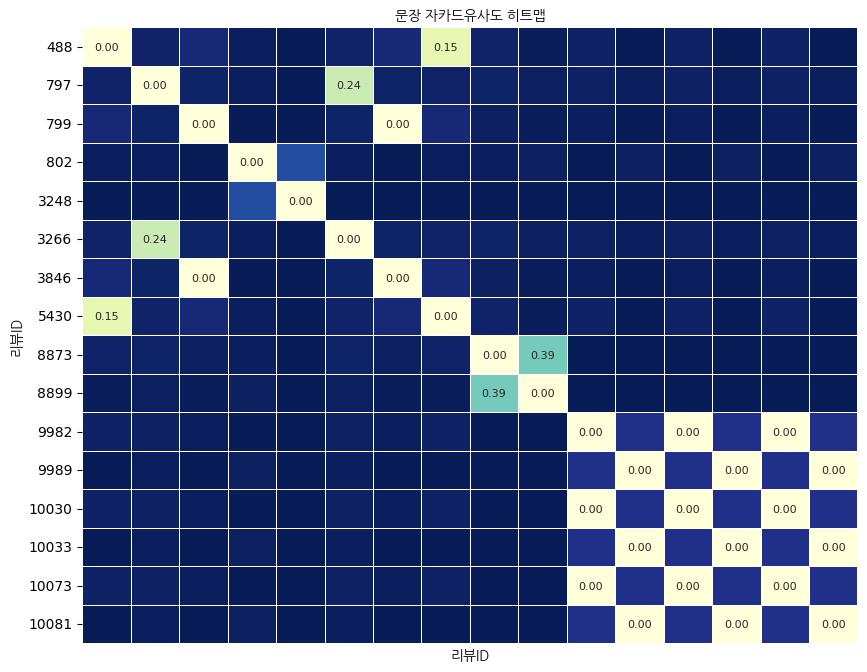

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances


# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_merged['리뷰'])

# 희소 행렬을 밀집 행렬로 변환
X_dense = X.toarray()

# 자카드 유사도 계산
jaccard_distances = pairwise_distances(X_dense, metric='jaccard')

# 0.1 이상인 수치만 표기할 수 있도록 마스크 생성
masked_distances = np.where(jaccard_distances >= 0.1, jaccard_distances, np.nan)

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_distances, annot=True, cmap='YlGnBu', xticklabels=df_merged['리뷰ID'], yticklabels=df_merged['리뷰ID'], fmt=".2f", cbar=False, annot_kws={"size": 10}, linewidths=0.5)
plt.title("문장 자카드유사도 히트맵", fontproperties=font_prop)
plt.xlabel("리뷰ID", fontproperties=font_prop)
plt.ylabel("리뷰ID", fontproperties=font_prop)

# 플롯의 축을 왼쪽 정렬
plt.tick_params(axis='both', labelleft=True, labeltop=False, labelright=False, labelbottom=False, bottom=False, top=False, left=True, right=False)

# 텍스트 숨기기
for text in plt.gca().texts:
    if float(text.get_text()) > 0.5:
        text.set_text('')

# 숫자 폰트 크기 조정
plt.setp(plt.gca().texts, fontsize=8)

# 그래프 출력
plt.show()


### 유클리디안 거리 유사도
 TF-IDF는 문서에서 각 단어의 중요도를 계산하는 방법 중 하나입니다. 이를 통해 문장의 벡터 표현을 만들고, 벡터 간의 유클리디안 거리를 계산하여 유사도를 측정할 수 있습니다.

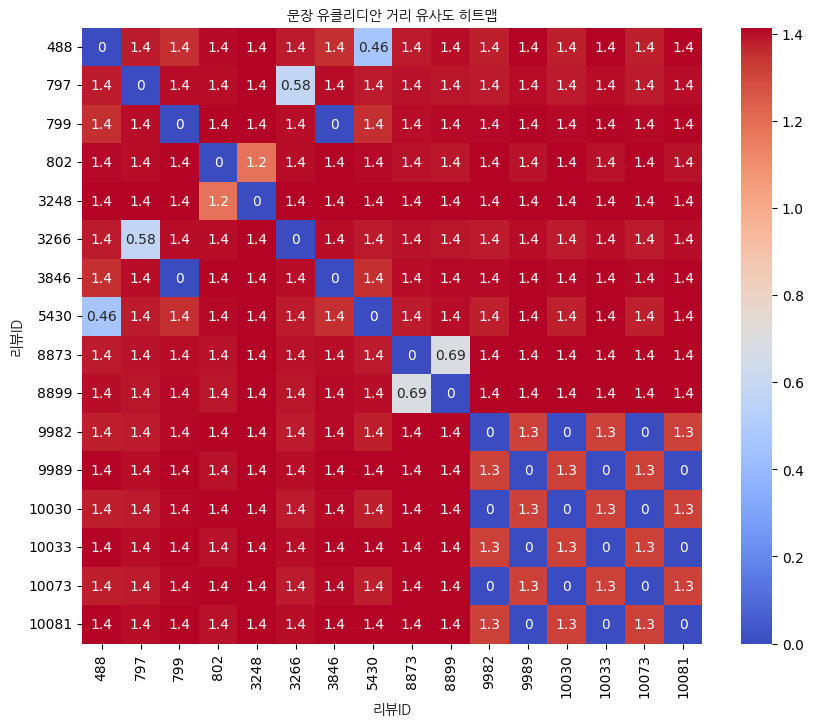

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 리뷰문장토큰 열을 가져와서 리스트로 변환
review = df_merged['리뷰'].tolist()

# TF-IDF 벡터화 객체 생성 및 학습
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(review)

# 벡터 간의 유클리디안 거리 계산
distances = euclidean_distances(tfidf_matrix)

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(distances, annot=True, cmap='coolwarm', xticklabels=df_merged['리뷰ID'], yticklabels=df_merged['리뷰ID'])
plt.xlabel('리뷰ID', fontproperties=font_prop)
plt.ylabel('리뷰ID', fontproperties=font_prop)
plt.title('문장 유클리디안 거리 유사도 히트맵', fontproperties=font_prop)
plt.show()
